In [3]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
# from sklearn_pandas import CategoricalImputer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

warnings.filterwarnings('ignore')

In [4]:
data_path = Path("../input/titanic-dataset/Titanic-Dataset.csv")

In [5]:
def fit_predict_GridCV(X, y, pipe):
    params = {'classifier__n_estimators' : range(1, 20),
             'classifier__random_state' : range(1, 2)}
    grid = GridSearchCV(pipe, 
                       params,
                        cv=5, 
                       scoring='accuracy',
                       return_train_score=True)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)
    grid.fit(X_train, y_train)
    accuracy = grid.score(X_val, y_val)
#     preds = grid.predict(X_val)
#     accuracy = np.trace(confusion_matrix(y_val, preds, normalize='all'))
    return accuracy, grid

In [6]:
def load_data():
    # Read data
    df = pd.read_csv(data_path, index_col='PassengerId')
    return df

In [7]:
# Load data
df = load_data()
df.shape[0]  # Total number of data points. : 891

891

In [8]:
df.info(), df.nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


(None,
 Survived      2
 Pclass        3
 Name        891
 Sex           2
 Age          88
 SibSp         7
 Parch         7
 Ticket      681
 Fare        248
 Cabin       147
 Embarked      3
 dtype: int64)

In [9]:
feats = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
target = ['Survived']

In [10]:
X = df[feats]
y = df[target]

<br><br>

In [11]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
imp = SimpleImputer(strategy='median')

ct = ColumnTransformer([('onehotencoder', ohe, ['Sex']), ('imputer', imp, ['Age'])], remainder='passthrough')

In [12]:
res = ct.fit_transform(df[feats+target])

In [13]:
new_featName = [i.split('_')[-1] for i in ct.get_feature_names_out()]

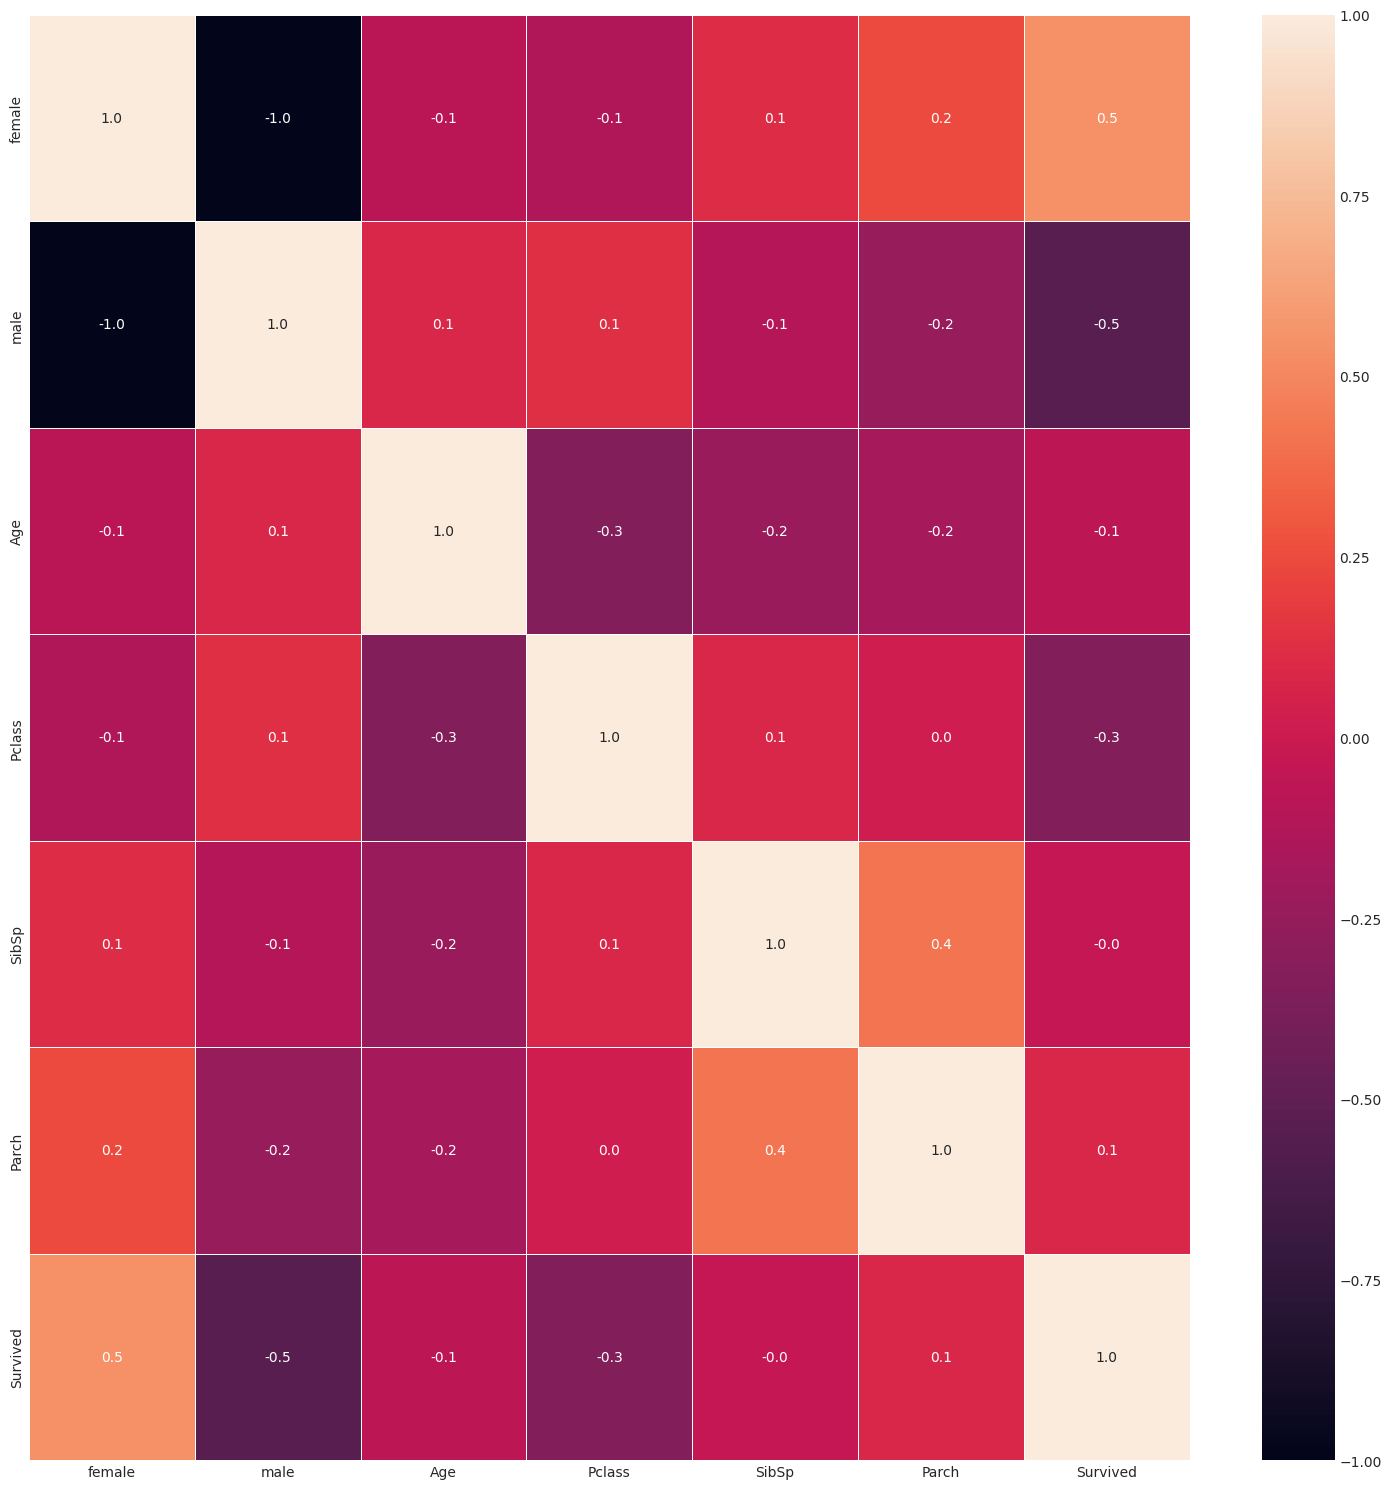

In [14]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(pd.DataFrame(res, columns=new_featName).corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()


<br><br>

In [15]:
clf = XGBClassifier()

pipe = Pipeline([
    ('preprocessor', ct), 
    ('classifier', clf)
])

In [16]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Sex']),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_b...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

In [18]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Sex']),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_b...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

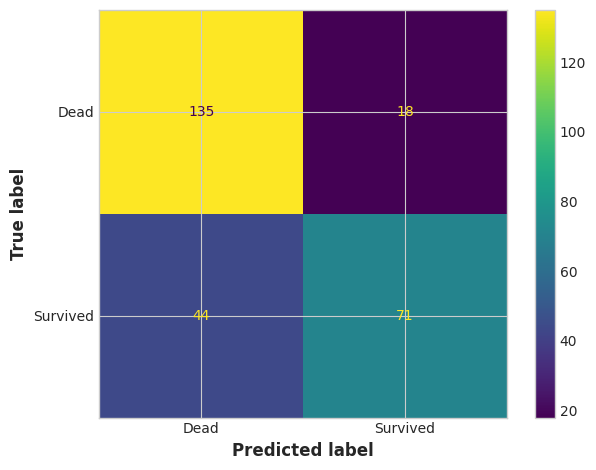

In [19]:
preds = pipe.predict(X_val)
ConfusionMatrixDisplay.from_predictions(y_val, preds, display_labels=['Dead', 'Survived'], )

In [20]:
np.trace(confusion_matrix(y_val, preds, normalize='all'))

0.7686567164179103

In [21]:
acc, grid = fit_predict_GridCV(X, y, pipe)

In [22]:
acc

0.753731343283582

<br><br><br>

In [23]:
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


(None,
 Survived      0
 Pclass        0
 Name          0
 Sex           0
 Age         177
 SibSp         0
 Parch         0
 Ticket        0
 Fare          0
 Cabin       687
 Embarked      2
 dtype: int64)

In [24]:
feats

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']

In [25]:
new_feats = feats + ['Fare', 'Embarked']

In [26]:
X_n = df[new_feats]
y_n = df[target]

In [27]:
X_n.isna().sum(), X_n.dtypes, X_n.nunique()

(Pclass        0
 Sex           0
 Age         177
 SibSp         0
 Parch         0
 Fare          0
 Embarked      2
 dtype: int64,
 Pclass        int64
 Sex          object
 Age         float64
 SibSp         int64
 Parch         int64
 Fare        float64
 Embarked     object
 dtype: object,
 Pclass        3
 Sex           2
 Age          88
 SibSp         7
 Parch         7
 Fare        248
 Embarked      3
 dtype: int64)

In [28]:
X_n['Embarked'].value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [29]:
cat_feats = ['Pclass', 'Sex', 'Embarked']
num_feats = ['Age']

In [30]:
num_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_trans = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, num_feats),
    ('cat', cat_trans, cat_feats)
], remainder='passthrough')

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

In [31]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('classifier',
                 XGBClassifier(base_score=None, boo...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [32]:
acc_n, grid_n = fit_predict_GridCV(X_n, y_n, pipe)

In [33]:
acc_n

0.7723880597014925